In [1]:
from Nowack_Lab.Utilities import multih5
import numpy as np
from os.path import basename
import time
import yaml

Current experimental save paths:
./Nowack_Lab_data/2022-09-28_ns5-PPMS-IV


New experiment? y/(n):  n


SAMBASHARE not connected. Could not find path /mnt/labshare/data/. If you want to change the expected path, modify the get_data_server_path function in Nowack_Lab/Utilities/save.py


## Measurement and saving

In [58]:
import Nowack_Lab.Instruments.zurich as zurich
hf2li = zurich.HF2LI1(server_port=8004, device_serial='HF2-DEV505')
instruments = {
    'zurich': hf2li,
}

In [59]:
hf2li.poll()

{}

In [2]:
import Nowack_Lab.Instruments.keithley as keithley
import Nowack_Lab.Instruments.hp8753d as hp8753d
keithley2450 = keithley.Keithley2450()

In [3]:
vna = hp8753d.VNA8753D()
instruments = {
    'keithley': keithley2450,
    'vna': vna,
}

In [2]:
# For now, metadata must not have nested objects
metadata = yaml.safe_load('''
name: NS5 PPMS IV measurement
author name: Alex Striff
author email: abs299@cornell.edu
description: >
  IV curves for nanosquids for different magnetic fields through the loop.
format: >
  Dataset dimension label <x> is the sweep of scales/<x>.
  Units are given in the 'unit' attribute.
''')

In [3]:
initial_configuration = yaml.safe_load('''
keithley:
  source: 'I'
  Iout_range: 1.0e-3 #A
  # V_compliance: 5.0 #V
  output: 'on'
  Iout: 0.0e-3 #A
vna:
  networkparam: 'S21'
  power: -10.0 #dBm
  power_range_auto: False
  minfreq: 3.0e+9 #Hz
  maxfreq: 6.0e+9 #Hz
  sweeptime: 1.0 #s
  sweepmode: 'LIN'
  numpoints: 1601
  averaging_state: 1 #on
  averaging_factor: 100
  IF_bandwidth: 3000 #Hz
''')

In [6]:
for instrument, settings in initial_configuration.items():
    i = instruments[instrument]
    for k, v in settings.items():
        setattr(i, k, v)

There is sometimes a jump on the lowest frequency, so do one throwaway sweep before taking data.

In [4]:
def add_scale(f, name, unit, x):
    path = 'scales/{}'.format(name)
    f[path] = x
    f[path].attrs['unit'] = unit
    return x

In [5]:
filenames = []
with multih5.Files('ns5-IV', 'w',
                   libver = 'latest',
                  ) as fs:
    for f in fs:
        filenames.append(f.filename)
        
        # Write metadata
        for k, v in metadata.items():
            f.attrs[k] = v
        

./Nowack_Lab_data/2022-09-28_ns5-PPMS-IV/2022-09-28_162946_rf-new-squid-modulation.hdf5


In [25]:
    # Initial instrument states
    for name, instrument in instruments.items():
        for k, v in instrument.__getstate__().items():
            for f in fs:
                f['instruments/{}/{}'.format(name, k)] = v

    # Keithley 2450 needs some time, or else setting current doesn't work
    time.sleep(0.1) #s

    # Sweep scales
    currents, freqs = scales = [
        ('Field coil current', 'A', np.arange(0, 0.4e-3, 0.05e-3)),
#     powers, freqs = scales = [
#         ('Source power', 'dBm', np.linspace(
#             -12.0, -7.0,
#             num = 21,
#         )),
        ('Frequency', 'Hz', vna.frequencies()),
    ]
    for f in fs:
        for scale in scales:
            add_scale(f, *scale)
    shape = tuple(len(scale[2]) for scale in scales)

    # Sweep variables
    for f in fs:
        re = f.create_dataset('S21_re', shape)
        re.attrs['description'] = '$\Re S_{21}$'
        re.attrs['unit'] = 'U'
        
        im = f.create_dataset('S21_im', shape)
        im.attrs['description'] = '$\Im S_{21}$'
        im.attrs['unit'] = 'U'
        
        datasets = [re, im]
        for x in datasets:
            for i, scale in enumerate(scales):
                x.dims[i].label = basename(scale[0])
            
        f.swmr_mode = True # Now we should only modify data

    for i, I in enumerate(currents[2]):
#         instruments['keithley'].Iout = I
#         time.sleep(0.1) #s
        # Keithley driver problems, so set manually for now
        input(prompt='{}'.format(I))
#     for i, P in enumerate(powers[2]):
#         instruments['vna'].power = P
#         time.sleep(0.1) #s
        # Freq sweep returns the sweep array
        S21_reim = instruments['vna'].reim()
        for f in fs:
            f['S21_re'][i,:] = S21_reim[0,:]
            f['S21_im'][i,:] = S21_reim[1,:]

D:\data\Orenstein\experiments\2022-06-24_RF-SQUID-modulation\2022-06-28_211012_rf-new-squid-modulation.hdf5
Z:\data\DESKTOP-6212UG8\experiments\2022-06-24_RF-SQUID-modulation\2022-06-28_211012_rf-new-squid-modulation.hdf5
0.0
5e-05
0.0001
0.00015000000000000001
0.0002
0.00025
0.00030000000000000003
0.00035


## Plotting

In [26]:
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path

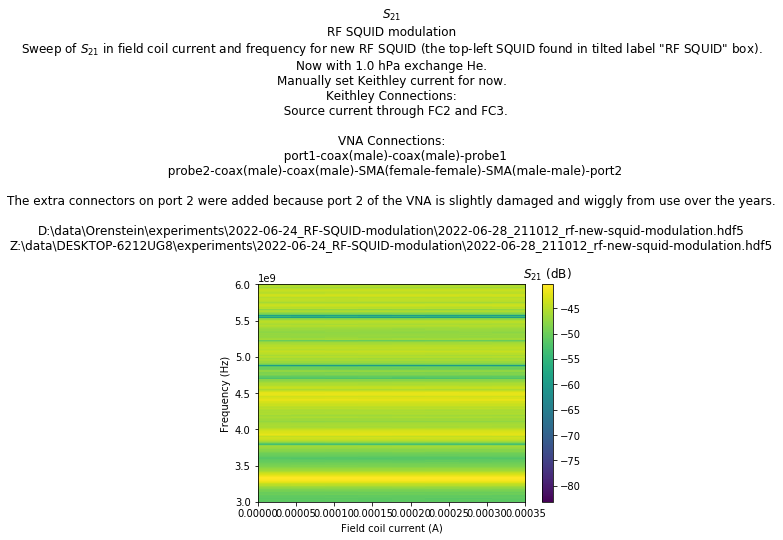

In [28]:
plotfile = filenames[0]
with h5.File(plotfile,
             'r',
             libver = 'latest',
             swmr = True,
            ) as f:
    # Assume 2D data in x
    x, y = f['S21_re'], f['S21_im']
    labels = [d.label for d in x.dims]
    scales = [f['scales/{}'.format(l)] for l in labels]
    scaledata = [s[:] for s in scales]
    scaleunits = [s.attrs['unit'] for s in scales]
    scalelabels = ['{} ({})'.format(l, u) for l, u in zip(labels, scaleunits)]
    plt.imshow(np.transpose(20*np.log10(np.sqrt(x[:]**2 + y[:]**2))),
               origin = 'lower',
               extent = (
                   scaledata[-2].min(), scaledata[-2].max(),
                   scaledata[-1].min(), scaledata[-1].max(),
               ),
               cmap = cm.viridis,
               aspect = 'auto',
              )
    plt.title('\n'.join([
        "$S_{21}$",
        f.attrs['name'],
        f.attrs['description'],
        *filenames,
        '',''
    ]))
    plt.xlabel(scalelabels[-2])
    plt.ylabel(scalelabels[-1])
    cb = plt.colorbar()
    cb.ax.set_title('{} ({})'.format('$S_{21}$', 'dB'))
    
    for file in filenames:
        plt.savefig(Path(file).with_suffix('.pdf'),
                    dpi = 600,
                    bbox_inches='tight',
                   )
    plt.show()